In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
new_transactions = pd.read_csv('./input/new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('./input/historical_transactions.csv', parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

historical_transactions[:5]


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [5]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df
#_________________________________________
train = read_data('./input/train.csv')
test = read_data('./input/test.csv')

target = train['target']
del train['target']



In [6]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])


In [7]:
historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['sum', 'mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 1304.89 Mb (54.8% reduction)
Mem. usage decreased to 84.24 Mb (56.7% reduction)


In [8]:
historical_transactions[:5]


,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
115,0,C_ID_4e6213e9bc,88,0,0,842,M_ID_22c9cfa265,-10,-0.730379,2017-04-07 12:58:09,16,37,1,0,0,0,0,1,0,0
132,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:27,16,16,1,0,0,0,0,1,0,0
148,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:26,16,16,1,0,0,0,0,1,0,0
168,0,C_ID_4e6213e9bc,333,0,0,605,M_ID_c2ae34c2ef,0,-0.664262,2018-02-20 10:57:50,9,2,1,0,0,0,0,1,0,0
213,0,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-7,-0.738132,2017-07-08 07:33:31,16,34,1,0,0,0,0,1,0,0


In [9]:
auth_mean[:5]

,card_id,authorized_flag_sum,authorized_flag_mean
0,C_ID_00007093c1,114.0,0.765101
1,C_ID_0001238066,120.0,0.975610
2,C_ID_0001506ef0,62.0,0.939394
3,C_ID_0001793786,189.0,0.875000
4,C_ID_000183fdda,137.0,0.951389


In [10]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [11]:
historical_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,...,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C,purchase_month
115,0,C_ID_4e6213e9bc,88,0,0,842,M_ID_22c9cfa265,-10,-0.730379,2017-04-07 12:58:09,...,37,1,0,0,0,0,1,0,0,4
132,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:27,...,16,1,0,0,0,0,1,0,0,9
148,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:26,...,16,1,0,0,0,0,1,0,0,9
168,0,C_ID_4e6213e9bc,333,0,0,605,M_ID_c2ae34c2ef,0,-0.664262,2018-02-20 10:57:50,...,2,1,0,0,0,0,1,0,0,2
213,0,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-7,-0.738132,2017-07-08 07:33:31,...,34,1,0,0,0,0,1,0,0,7


In [12]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['min', 'max']
        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history


In [13]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]


,card_id,hist_transactions_count,hist_category_2_4.0_mean,hist_category_3_C_mean,hist_category_1_sum,hist_category_1_mean,hist_month_lag_min,hist_month_lag_max,hist_category_2_3.0_mean,hist_category_2_2.0_mean,...,hist_installments_std,hist_category_2_5.0_mean,hist_city_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_category_3_B_mean,hist_merchant_id_nunique
0,C_ID_00007093c1,35,0.0,0.171429,4.0,0.114286,-11,0,0.885714,0.000000,...,0.667367,0.000000,3,-14.401965,-0.411485,1.507069,-0.728876,0.430059,0.828571,11
1,C_ID_0001238066,3,0.0,0.000000,0.0,0.000000,-2,0,0.000000,0.000000,...,0.000000,0.666667,2,-1.789928,-0.596643,-0.596643,-0.596643,0.000000,1.000000,2
2,C_ID_0001506ef0,4,0.0,0.000000,0.0,0.000000,-8,0,1.000000,0.000000,...,0.500000,0.000000,1,-2.905782,-0.726445,-0.708590,-0.740491,0.016203,0.250000,4
3,C_ID_0001793786,27,0.0,0.000000,2.0,0.074074,-7,-1,0.111111,0.296296,...,0.395847,0.000000,8,-11.825338,-0.437975,1.236592,-0.745405,0.498150,0.185185,17
4,C_ID_000183fdda,7,0.0,0.571429,0.0,0.000000,-6,-4,1.000000,0.000000,...,2.288689,0.000000,1,-0.941381,-0.134483,0.334099,-0.714541,0.452741,0.428571,4


In [14]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_category_2_4.0_mean,auth_category_3_C_mean,auth_category_1_sum,auth_category_1_mean,auth_month_lag_min,auth_month_lag_max,auth_category_2_3.0_mean,auth_category_2_2.0_mean,...,auth_installments_std,auth_category_2_5.0_mean,auth_city_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_category_3_B_mean,auth_merchant_id_nunique
0,C_ID_00007093c1,114,0.0,0.157895,24.0,0.210526,-12,0,0.780702,0.000000,...,0.795159,0.008772,4,-62.443077,-0.547746,1.206539,-0.728876,0.237426,0.842105,28
1,C_ID_0001238066,120,0.0,0.266667,2.0,0.016667,-5,0,0.000000,0.000000,...,1.501050,0.150000,18,-70.657272,-0.588811,0.768095,-0.734887,0.192614,0.708333,65
2,C_ID_0001506ef0,62,0.0,0.000000,0.0,0.000000,-13,0,0.967742,0.000000,...,0.000000,0.000000,3,-31.696098,-0.511227,1.493545,-0.740491,0.484575,0.000000,28
3,C_ID_0001793786,189,0.0,0.000000,0.0,0.000000,-9,0,0.063492,0.359788,...,0.000000,0.000000,9,-24.960674,-0.132067,4.554145,-0.737892,0.867916,0.000000,114
4,C_ID_000183fdda,137,0.0,0.240876,4.0,0.029197,-5,0,0.905109,0.007299,...,2.108912,0.007299,9,-67.896553,-0.495595,2.764788,-0.737892,0.523760,0.729927,71


In [15]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]


,card_id,new_transactions_count,new_category_2_4.0_mean,new_category_3_C_mean,new_category_1_sum,new_category_1_mean,new_month_lag_min,new_month_lag_max,new_category_2_3.0_mean,new_category_2_2.0_mean,...,new_installments_std,new_category_2_5.0_mean,new_city_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_category_3_B_mean,new_merchant_id_nunique
0,C_ID_00007093c1,2,0.0,0.000000,0,0.000000,2,2,0.50000,0.000000,...,0.000000,0.000000,2,-1.328125,-0.664062,-0.656738,-0.671875,0.010704,1.000000,2
1,C_ID_0001238066,26,0.0,0.153846,2,0.076923,1,2,0.00000,0.000000,...,2.079941,0.115385,8,-14.851562,-0.571289,-0.078308,-0.740723,0.173462,0.807692,25
2,C_ID_0001506ef0,2,0.0,0.000000,0,0.000000,1,1,1.00000,0.000000,...,0.000000,0.000000,1,-1.447266,-0.723633,-0.715332,-0.731934,0.011742,0.000000,1
3,C_ID_0001793786,31,0.0,0.000000,0,0.000000,1,2,0.16129,0.258065,...,0.000000,0.032258,7,-0.229004,-0.007385,3.130859,-0.737793,0.947266,0.000000,31
4,C_ID_000183fdda,11,0.0,0.363636,0,0.000000,1,2,1.00000,0.000000,...,1.293340,0.000000,2,-6.589844,-0.599121,-0.107666,-0.732422,0.182861,0.545455,11


In [16]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(historical_transactions) 
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,...,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-5.500000,3.605551,2.916667,1.621354,-1.200164,0.999049,-0.431906,0.260478,-0.613764,...,3.750000,3.107908,1.176389,0.326634,1.000000,0.000000,1.500000,0.797724,0.355262,0.480551
1,C_ID_0001238066,-1.000000,1.414214,1.500000,0.707107,-0.894964,0.421890,-0.596643,0.000000,-0.596643,...,1.500000,0.707107,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,NaN
2,C_ID_0001506ef0,-3.333333,4.163332,1.333333,0.577350,-0.968594,0.395645,-0.731020,0.015849,-0.732397,...,0.333333,0.577350,0.166667,0.288675,0.000000,0.000000,0.333333,0.577350,0.707107,NaN
3,C_ID_0001793786,-3.833333,2.316607,4.500000,1.974842,-1.970890,2.037261,-0.423501,0.392159,-0.676499,...,0.833333,0.983192,0.291667,0.400520,0.166667,0.408248,0.500000,0.547723,0.179558,0.279244
4,C_ID_000183fdda,-5.000000,1.414214,3.500000,3.535534,-0.470690,0.344856,-0.376174,0.478523,-0.579708,...,9.500000,12.020815,2.000000,1.414214,1.000000,0.000000,3.500000,3.535534,2.366432,NaN
5,C_ID_00024e244b,-5.000000,4.000000,2.428571,1.397276,-1.186659,1.210810,-0.558085,0.326273,-0.607249,...,0.714286,1.112697,0.297619,0.419041,0.142857,0.377964,0.428571,0.534522,0.269338,0.312603
6,C_ID_0002709b5a,-7.250000,5.057997,1.500000,1.000000,-0.929675,0.699316,-0.604163,0.156637,-0.616865,...,2.750000,2.362908,2.250000,2.500000,2.250000,2.500000,2.250000,2.500000,0.000000,NaN
7,C_ID_00027503e2,-4.000000,2.915476,3.600000,1.516575,-2.669652,1.128393,-0.741249,0.002457,-0.742989,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-6.500000,3.535534,1.000000,0.000000,-0.617958,0.093896,-0.617958,0.093896,-0.617958,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
9,C_ID_0002ba3c2e,-3.666667,3.559026,2.500000,1.516575,-1.547448,0.910264,-0.641704,0.080430,-0.655965,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

In [18]:
train[:5]

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_2_4.0_mean,hist_category_3_C_mean,hist_category_1_sum,...,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,authorized_flag_sum,authorized_flag_mean
0,2017-06-01,C_ID_92a2005557,5,2,1,245,13.0,0.0,0.000000,0.0,...,0.319444,0.423007,0.166667,0.408248,0.5,0.547723,0.269338,0.312603,247.0,0.950000
1,2017-01-01,C_ID_3d0044924f,4,1,0,396,11.0,0.0,0.636364,2.0,...,4.033333,3.522310,3.500000,3.728270,5.0,4.289522,1.781853,2.519921,339.0,0.968571
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549,2.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,NaN,41.0,0.953488
3,2017-09-01,C_ID_186d6a6901,4,3,0,153,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,1.000000
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92,5.0,0.4,0.600000,3.0,...,6.500000,7.778175,6.500000,7.778175,6.5,7.778175,0.000000,0.000000,128.0,0.962406


In [104]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name not in ['card_id', 'first_active_month','feature_1','feature_2','feature_3']:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

train = normalize(train)
test = normalize(test)

In [19]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]

#features = ['auth_purchase_date_max','new_purchase_date_max','new_purchase_month_mean','new_purchase_amount_max','new_purchase_date_min','auth_purchase_date_ptp', 'new_purchase_date_ptp','hist_category_1_sum','auth_category_1_sum','auth_purchase_date_min']

In [20]:
features[:]

['feature_1',
 'feature_2',
 'feature_3',
 'elapsed_time',
 'hist_transactions_count',
 'hist_category_2_4.0_mean',
 'hist_category_3_C_mean',
 'hist_category_1_sum',
 'hist_category_1_mean',
 'hist_month_lag_min',
 'hist_month_lag_max',
 'hist_category_2_3.0_mean',
 'hist_category_2_2.0_mean',
 'hist_purchase_month_mean',
 'hist_purchase_month_max',
 'hist_purchase_month_min',
 'hist_purchase_month_std',
 'hist_purchase_date_ptp',
 'hist_purchase_date_min',
 'hist_purchase_date_max',
 'hist_category_2_1.0_mean',
 'hist_subsector_id_nunique',
 'hist_state_id_nunique',
 'hist_category_3_A_mean',
 'hist_merchant_category_id_nunique',
 'hist_installments_sum',
 'hist_installments_mean',
 'hist_installments_max',
 'hist_installments_min',
 'hist_installments_std',
 'hist_category_2_5.0_mean',
 'hist_city_id_nunique',
 'hist_purchase_amount_sum',
 'hist_purchase_amount_mean',
 'hist_purchase_amount_max',
 'hist_purchase_amount_min',
 'hist_purchase_amount_std',
 'hist_category_3_B_mean',
 '

In [21]:
categorical_feats[:]

['feature_1', 'feature_2', 'feature_3']

In [22]:
param = {'num_leaves': 100,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': 6,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
#         'device': 'gpu',
#         'gpu_platform_id': 0,
#         'gpu_device_id': 0
        }


In [23]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)
#    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
#    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))


fold n°0


/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73627	valid_1's rmse: 3.79163
[200]	training's rmse: 3.67738	valid_1's rmse: 3.74775
[300]	training's rmse: 3.63921	valid_1's rmse: 3.72446
[400]	training's rmse: 3.61264	valid_1's rmse: 3.71146
[500]	training's rmse: 3.59202	valid_1's rmse: 3.70333
[600]	training's rmse: 3.57561	valid_1's rmse: 3.69757
[700]	training's rmse: 3.5629	valid_1's rmse: 3.6939
[800]	training's rmse: 3.55092	valid_1's rmse: 3.69106
[900]	training's rmse: 3.54039	valid_1's rmse: 3.68908
[1000]	training's rmse: 3.53027	valid_1's rmse: 3.68747
[1100]	training's rmse: 3.52061	valid_1's rmse: 3.68619
[1200]	training's rmse: 3.51127	valid_1's rmse: 3.6853
[1300]	training's rmse: 3.50195	valid_1's rmse: 3.68456
[1400]	training's rmse: 3.493	valid_1's rmse: 3.68422
[1500]	training's rmse: 3.48464	valid_1's rmse: 3.68384
[1600]	training's rmse: 3.47622	valid_1's rmse: 3.68348
[1700]	training's rmse: 3.46802	valid_1's rmse: 3.68325

/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.75365	valid_1's rmse: 3.72231
[200]	training's rmse: 3.69324	valid_1's rmse: 3.68392
[300]	training's rmse: 3.6539	valid_1's rmse: 3.66436
[400]	training's rmse: 3.62489	valid_1's rmse: 3.65319
[500]	training's rmse: 3.60412	valid_1's rmse: 3.64648
[600]	training's rmse: 3.58729	valid_1's rmse: 3.64163
[700]	training's rmse: 3.57304	valid_1's rmse: 3.63822
[800]	training's rmse: 3.56061	valid_1's rmse: 3.63565
[900]	training's rmse: 3.54902	valid_1's rmse: 3.63395
[1000]	training's rmse: 3.53804	valid_1's rmse: 3.63263
[1100]	training's rmse: 3.52854	valid_1's rmse: 3.63139
[1200]	training's rmse: 3.51875	valid_1's rmse: 3.63035
[1300]	training's rmse: 3.50989	valid_1's rmse: 3.62999
[1400]	training's rmse: 3.501	valid_1's rmse: 3.62927
[1500]	training's rmse: 3.49216	valid_1's rmse: 3.6287
[1600]	training's rmse: 3.48381	valid_1's rmse: 3.62827
[1700]	training's rmse: 3.47639	valid_1's rmse: 3.6279

/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.75753	valid_1's rmse: 3.69645
[200]	training's rmse: 3.69739	valid_1's rmse: 3.65874
[300]	training's rmse: 3.65844	valid_1's rmse: 3.64013
[400]	training's rmse: 3.63021	valid_1's rmse: 3.62945
[500]	training's rmse: 3.6094	valid_1's rmse: 3.62245
[600]	training's rmse: 3.59293	valid_1's rmse: 3.61745
[700]	training's rmse: 3.57843	valid_1's rmse: 3.61426
[800]	training's rmse: 3.56617	valid_1's rmse: 3.61244
[900]	training's rmse: 3.55535	valid_1's rmse: 3.61094
[1000]	training's rmse: 3.54461	valid_1's rmse: 3.61002
[1100]	training's rmse: 3.53509	valid_1's rmse: 3.60944
[1200]	training's rmse: 3.52593	valid_1's rmse: 3.60879
[1300]	training's rmse: 3.51757	valid_1's rmse: 3.60815
[1400]	training's rmse: 3.50904	valid_1's rmse: 3.60793
[1500]	training's rmse: 3.50061	valid_1's rmse: 3.60791
[1600]	training's rmse: 3.49199	valid_1's rmse: 3.60777
[1700]	training's rmse: 3.48337	valid_1's rmse: 3.6

/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71112	valid_1's rmse: 3.89308
[200]	training's rmse: 3.65194	valid_1's rmse: 3.84964
[300]	training's rmse: 3.61273	valid_1's rmse: 3.82661
[400]	training's rmse: 3.58438	valid_1's rmse: 3.81397
[500]	training's rmse: 3.56218	valid_1's rmse: 3.80611
[600]	training's rmse: 3.54484	valid_1's rmse: 3.80158
[700]	training's rmse: 3.531	valid_1's rmse: 3.79864
[800]	training's rmse: 3.51867	valid_1's rmse: 3.79681
[900]	training's rmse: 3.50735	valid_1's rmse: 3.79527
[1000]	training's rmse: 3.4975	valid_1's rmse: 3.7943
[1100]	training's rmse: 3.48837	valid_1's rmse: 3.79338
[1200]	training's rmse: 3.47934	valid_1's rmse: 3.79277
[1300]	training's rmse: 3.47112	valid_1's rmse: 3.79231
[1400]	training's rmse: 3.46293	valid_1's rmse: 3.79208
[1500]	training's rmse: 3.45527	valid_1's rmse: 3.79173
[1600]	training's rmse: 3.44791	valid_1's rmse: 3.79143
[1700]	training's rmse: 3.43976	valid_1's rmse: 3.7912

/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/learningai/.local/lib/python3.5/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.75596	valid_1's rmse: 3.71102
[200]	training's rmse: 3.69446	valid_1's rmse: 3.67366
[300]	training's rmse: 3.65406	valid_1's rmse: 3.65561
[400]	training's rmse: 3.62552	valid_1's rmse: 3.64538
[500]	training's rmse: 3.6034	valid_1's rmse: 3.63811
[600]	training's rmse: 3.58571	valid_1's rmse: 3.63388
[700]	training's rmse: 3.57096	valid_1's rmse: 3.6312
[800]	training's rmse: 3.55775	valid_1's rmse: 3.6291
[900]	training's rmse: 3.54585	valid_1's rmse: 3.62753
[1000]	training's rmse: 3.53494	valid_1's rmse: 3.62655
[1100]	training's rmse: 3.52518	valid_1's rmse: 3.62562
[1200]	training's rmse: 3.51632	valid_1's rmse: 3.62519
[1300]	training's rmse: 3.50724	valid_1's rmse: 3.62475
[1400]	training's rmse: 3.49865	valid_1's rmse: 3.62419
[1500]	training's rmse: 3.48974	valid_1's rmse: 3.62386
[1600]	training's rmse: 3.48138	valid_1's rmse: 3.62366
[1700]	training's rmse: 3.47335	valid_1's rmse: 3.623

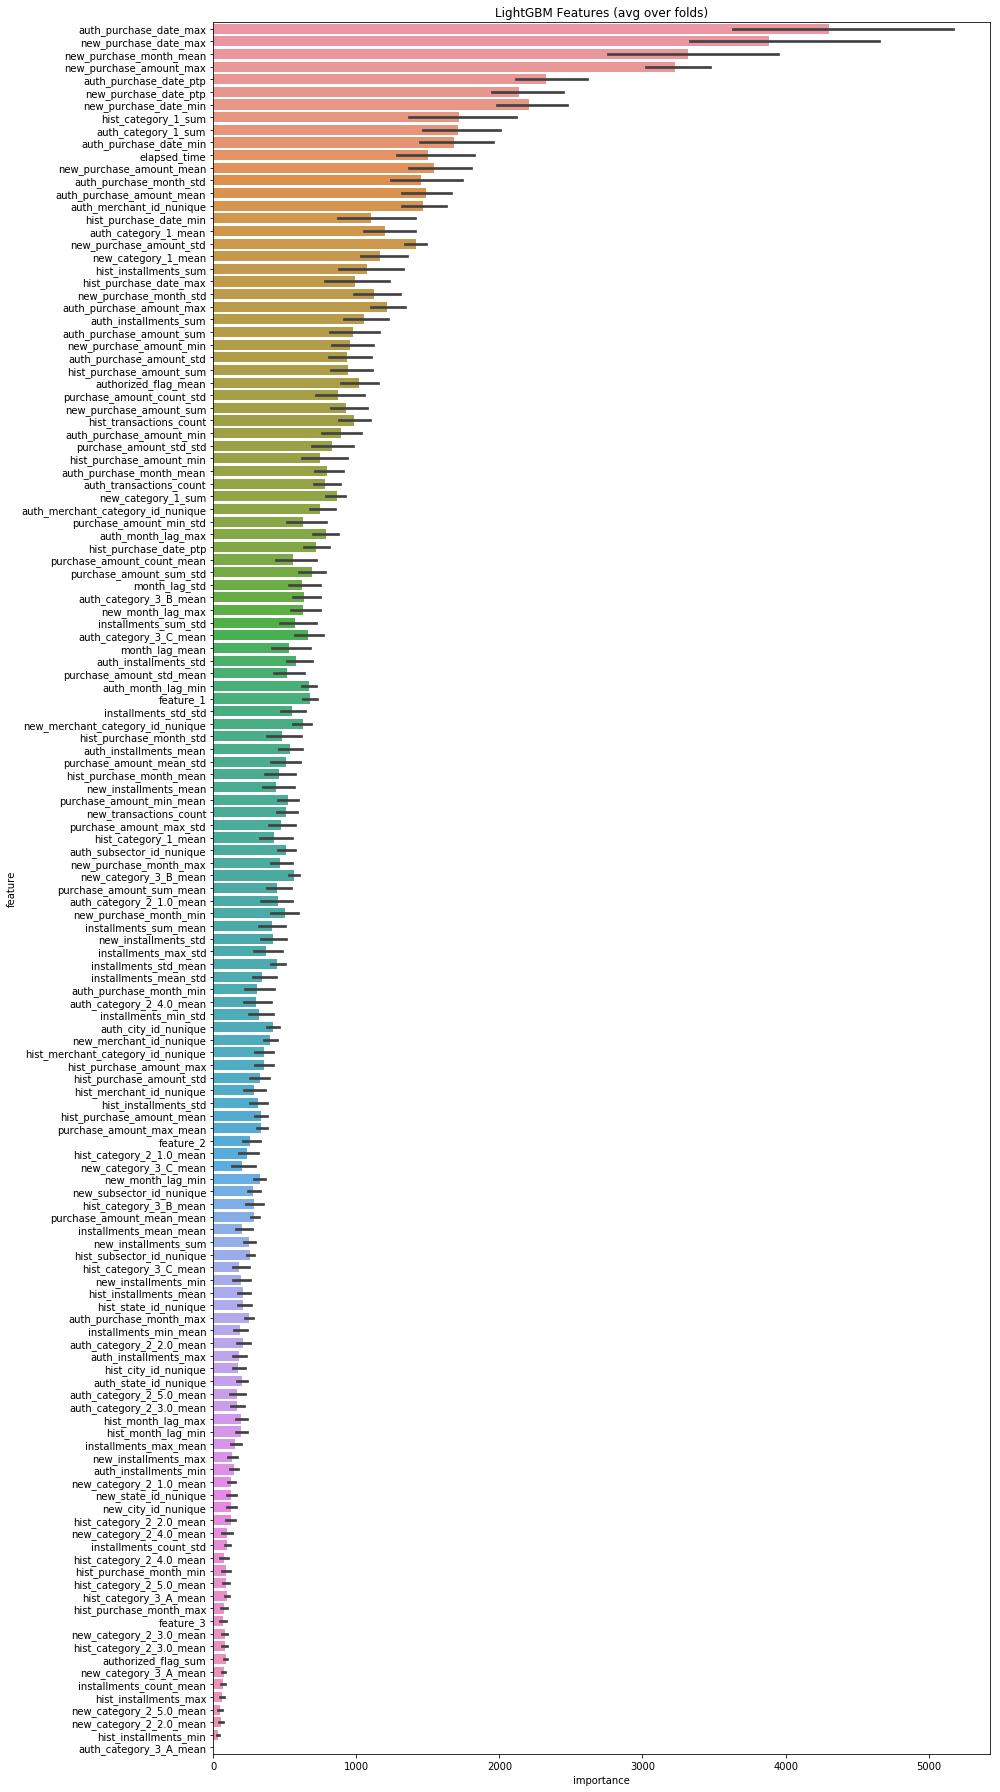

In [24]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [25]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)
